In [65]:
# Name - Dev Patel
# Roll No - 18110113

import numpy as np
import scipy
import scipy.integrate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [66]:
# Getting the tajectory 
x = np.array([])
vx = np.array([])
ax = np.array([])

y = np.array([])
vy = np.array([])
ay = np.array([])

z = np.array([])
vz = np.array([])
az = np.array([])

T = np.array([])
for t in range(0,101,1):
    x = np.append(x,0.4)
    vx = np.append(vx,0)
    ax = np.append(ax,0)
    
    y = np.append(y,0.06 -0.5*((t/100)**3)+0.75*((t/100)**4)-0.3*((t/100)**5))
    vy = np.append(vy,-3*0.5*((t/100)**2)+4*0.75*((t/100)**3)-5*0.3*((t/100)**4))
    ay =np.append(ay,-6*0.5*((t/100))+12*0.75*((t/100)**2)-20*0.3*((t/100)**3))
    
    z = np.append(z,0.1)
    vz = np.append(vz,0)
    az = np.append(az,0)

    T = np.append(T,t/100)

In [67]:
# SCARA manipulator
d1 = 0.25
# Some constants
l1 = 0.25
l2 = 0.25
l3 = 0.25
def inverse_kinematics_SCARA(O):

    c2 = (O[0]**2 + O[1]**2 - l1**2 - l2**2)/(2*l1*l2)
    theta2 = np.arctan2(-(1-c2**2)**0.5,c2)
    theta1 = np.arctan2(O[1],O[0]) - np.arctan2(l2*np.sin(theta2),l1 + l2*np.cos(theta2))

    d3 = d1 - O[2] 

    I = np.array([theta1,theta2,d3])
    return(I)

q1 = np.array([])
q2 = np.array([])
d3 = np.array([])
for i in range(len(x)):
    I = inverse_kinematics_SCARA([x[i],y[i],z[i]])
    q1 = np.append(q1,I[0])
    q2 = np.append(q2,I[1])
    d3 = np.append(d3,I[2])



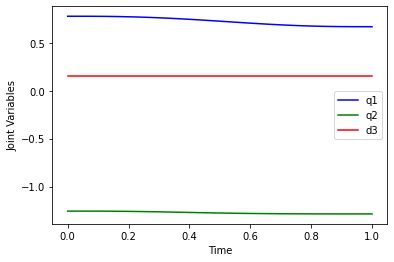

In [68]:
# Plot joint tajectories

plt.plot(T,q1,'b',T,q2,'g',T,d3,'r')
plt.xlabel('Time')
plt.ylabel('Joint Variables')
plt.legend(['q1','q2','d3'])


In [69]:
# Get a skew symmetric matrix for a given 3x1 matrix
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

def Jacobian_SCARA(DH_parameters):
    T = np.eye(4)
    O = np.array([0,0,0])
    Z = np.array([0,0,1])
    for i in range(4):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])
        T = np.dot(T,A)
        O = np.c_[O,np.transpose(T[:3,3])]
        Z = np.c_[Z,np.transpose(T[:3,2])]
    J = np.r_[np.dot(skew(Z[:,0]),np.transpose(O[:,3]) - np.transpose(O[:,0])), np.transpose(Z[:,0])]
    for i in range(1,4):
        if(i==4):
             J = np.c_[J,np.r_[np.transpose(Z[:,i]),np.transpose([0,0,0])]]
        else:
            J = np.c_[J,np.r_[np.dot(skew(Z[:,i]),np.transpose(O[:,3]) - np.transpose(O[:,i])), np.transpose(Z[:,i])]]
    return(J)

# Get desired joint velocity
q1_dot = np.array([])
q2_dot = np.array([])
d3_dot = np.array([])

for i in range(len(x)):
    V = np.array([vx[i],vy[i],vz[i],0,0,0])
    I = inverse_kinematics_SCARA([x[i],y[i],z[i]])
    DH = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l1,0,3.14],[0,0,I[2],0]])
    J = Jacobian_SCARA(DH)
    q_dot = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(V[:3]))
    q1_dot = np.append(q1_dot,q_dot[1])
    q2_dot = np.append(q2_dot,q_dot[2])
    d3_dot = np.append(d3_dot,q_dot[3])
    



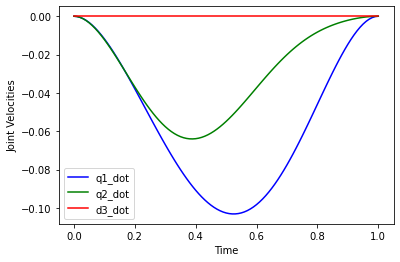

In [70]:
# Plot joint velocity tajectories

plt.plot(T,q1_dot,'b',T,q2_dot,'g',T,d3_dot,'r')
plt.xlabel('Time')
plt.ylabel('Joint Velocities')
plt.legend(['q1_dot','q2_dot','d3_dot'])

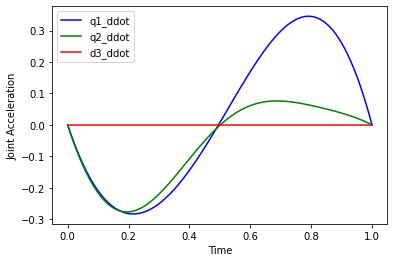

In [71]:
# Get desired joint acceleration
q1_ddot = np.array([])
q2_ddot = np.array([])
d3_ddot = np.array([])
for i in range(0,101,1):
    A_e = np.array([ax[i],ay[i],az[i],0,0,0])
    I = inverse_kinematics_SCARA([x[i],y[i],z[i]])
    DH = np.array([[0,0,d1,0],[I[0],l1,0,0],[I[1],l1,0,3.14],[0,0,I[2],0]])
    J = Jacobian_SCARA(DH)
    J_dot = [[-l1*np.cos(q1[i])*q1_dot[i]-l2*np.cos(q1[i]+q2[i])*(q1_dot[i]+q2_dot[i]),-l2*np.cos(q1[i]+q2[i])*(q1_dot[i]+q2_dot[i]),0],[-l1*np.sin(q1[i])*(q1_dot[i])-l2*np.sin(q1[i]+q2[i])*(q1_dot[i]+q2_dot[i]),-l2*np.sin(q1[i]+q2[i])*(q1_dot[i]+q2_dot[i]),0],[0,0,0]]
    H = np.matmul(np.linalg.pinv(J[:3,:]),np.transpose(A_e[:3])) 
    G = np.matmul(J_dot[:3],np.transpose(np.array([q1_dot[i],q2_dot[i],d3_dot[i]])))
    q_ddot_d = H[1:] - G
    q1_ddot = np.append(q1_ddot,q_ddot_d[0])
    q2_ddot = np.append(q2_ddot,q_ddot_d[1])
    d3_ddot = np.append(d3_ddot,q_ddot_d[2])


# Plot joint acceleration tajectories

plt.plot(T,q1_ddot,'b',T,q2_ddot,'g',T,d3_ddot,'r')
plt.xlabel('Time')
plt.ylabel('Joint Acceleration')
plt.legend(['q1_ddot','q2_ddot','d3_ddot'])